## Imports and Data

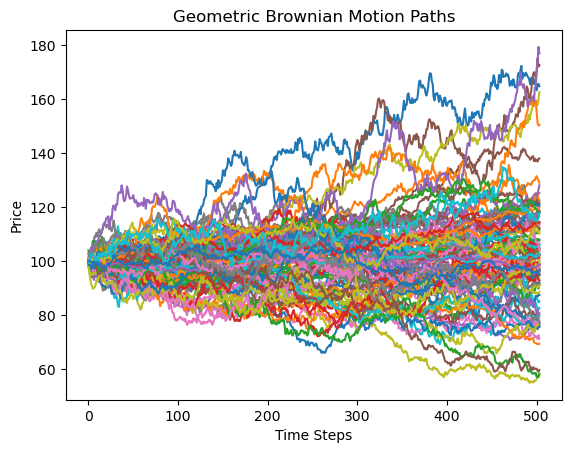

In [1]:
import pandas as pd
from sklearn.linear_model import Lasso, LinearRegression
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn import linear_model as lm
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(25)  # Set the seed
# np.random.seed(42)  # Set the seed

# Set the parameters for your GBMs
num_paths = 101
days = 252*2
num_steps = days  # Number of time steps (e.g., trading days in a year)
dt = 1/(days)  # Time step size (daily)

# Initialize empty arrays to store the paths
paths = np.zeros((num_paths, num_steps + 1))

# Define the characteristics of each GBM
mean_values = np.random.uniform(0, 0.10, num_paths)  # Mean returns
volatility_values = np.random.uniform(0.05, 0.30, num_paths)  # Volatilities
starting_points = 100  # Starting points

for i in range(num_paths):
    # Generate a GBM path for each set of characteristics
    mean_return = mean_values[i]
    volatility = volatility_values[i]
    starting_point = 100
    
    # Generate the Wiener process (Brownian motion)
    brownian_motion = np.random.randn(num_steps) * np.sqrt(dt)

    # Compute the GBM path
    cumulative_returns = (mean_return - 0.5 * volatility ** 2) * dt * np.arange(num_steps)
    cumulative_brownian = np.cumsum(brownian_motion)
    paths[i, 1:] = starting_point * np.exp(cumulative_returns + volatility * cumulative_brownian)

# Plot the GBM paths
for i in range(num_paths):
    plt.plot(np.arange(num_steps), paths[i, 1:])

plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.title('Geometric Brownian Motion Paths')
plt.show()


In [2]:
def generate_index(X): 
    rweights = np.random.uniform(0,1,X.shape[1])
    rweights = rweights/np.sum(rweights)

    portfolio = np.dot(X,rweights)

    return portfolio, rweights 


X = np.diff(paths) / (paths[:,:-1] + 1e-10) # Use all 100 sample paths for X
X[:,0] = 0 # Set the first return to 0

index, rweights = generate_index(paths)

Y = np.diff(index) / (index[:-1] + 1e-10) # Use a single path for Y
Y[0] = 0 # Set the first return to 0

### Here I tried to get some real data but didn't succeed:

In [3]:
returns = pd.read_csv('Index_Replication_Data/X_USD.csv', index_col=0, header=0, parse_dates=True, keep_default_na=True, na_values=['NA'], delimiter=';', decimal=",")
returns.dropna(axis=1, inplace=True)
returns = returns[returns.index.dayofweek < 5]

X = returns[returns.columns[:-100]].values

index, rweights = generate_index(returns[returns.columns[-100:]])
Y = index

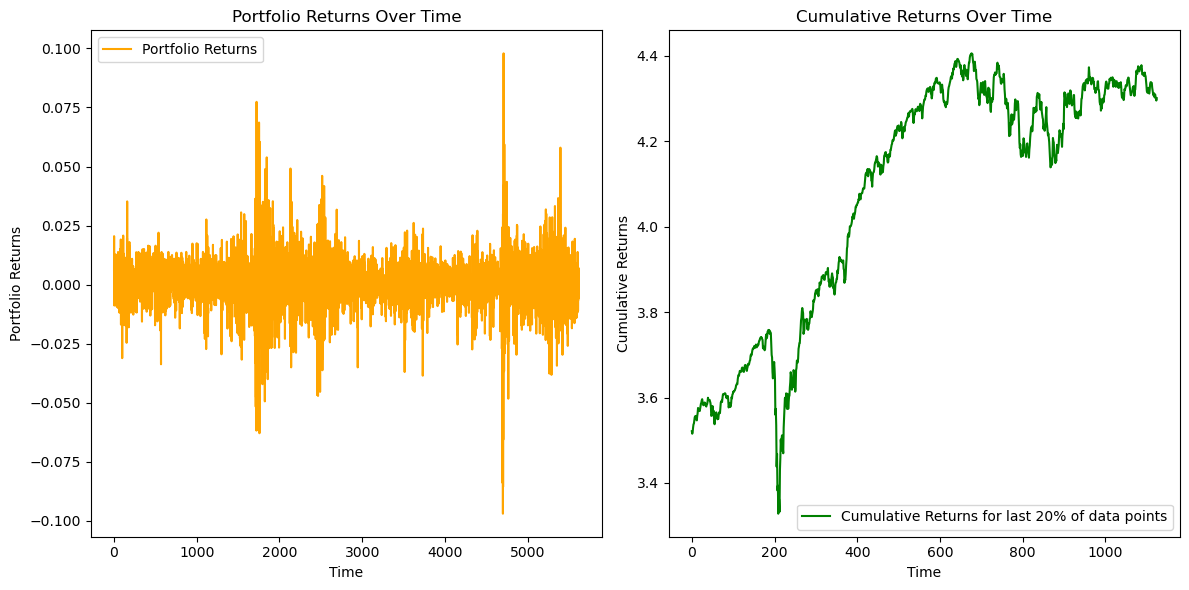

In [4]:
# Calculate cumulative portfolio returns
cumulative_returns = np.cumsum(Y)

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(Y, label='Portfolio Returns', color='orange')
plt.title('Portfolio Returns Over Time')
plt.xlabel('Time')
plt.ylabel('Portfolio Returns')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cumulative_returns[int(0.8 * len(Y)):], label='Cumulative Returns for last 20% of data points', color='green')
plt.title('Cumulative Returns Over Time')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.legend()

plt.tight_layout()
plt.show()

## Simple Lasso - only once (without rebalancing):

In [5]:
def regression1(x_train, y_train, x_test, y_test, alpha, plot=False):
    # Create and train the Lasso regression model
    lasso = Lasso(alpha=alpha, positive = True)  # You can adjust the regularization strength (alpha) as needed
    lasso.fit(x_train, y_train)
    w = lasso.coef_
    # Predict on the test data
    Y_pred = lasso.predict(x_test)
    
    if np.any(w < 0):
        print("WARNING: Some elements in 'w' are negative.")

    if plot:
        plt.plot(y_test, label='Y_test')
        plt.plot(Y_pred, label='Y_pred')
        plt.title('Lasso regression ')
        plt.legend()
        plt.show()
    return  w

(140,)
Best alpha: 2.5005000000000002e-05


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.120e-07, tolerance: 9.185e-08
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 40
Mean Squared Error for best alpha on test set: 3.94140413466698e-05
MSE for cumulative gains (portfolio value): 0.1722467597550796
MSE for cumulative losses (portfolio value): 8.615858854609134e-06


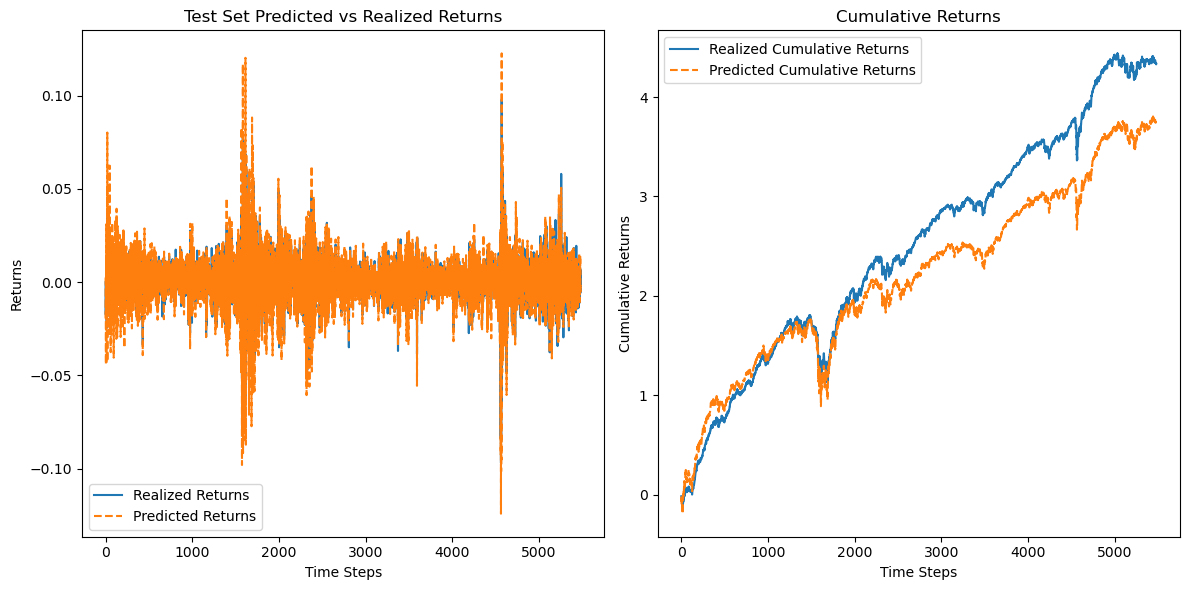

In [6]:
#split_index = int(0.8 * X.shape[0])  # Use 80% of the data for training
split_index = 28*5

X_train, Y_train = X[:split_index], Y[:split_index]
X_test, Y_test = X[split_index:], Y[split_index:]

days = X_train.shape[0]
print(Y_train.shape)

# Transpose X_train and X_test to match the previous code
#X_train, X_test = X_train.T, X_test.T

folds = int(np.floor(days/28))
alpha = np.linspace(10e-9, 5*10e-6, folds) 
validation_itr = TimeSeriesSplit(n_splits=folds).split(X_train, Y_train)
plot = False

min_scorel = np.Infinity
best_alpha = None


# WITHOUT T COSTS, RUN ON REGRESSION1 FUNCTION
for j, (train_idx, test_idx) in enumerate(validation_itr):
    w = regression1(X_train[train_idx], Y_train[train_idx], X_train[test_idx], Y_train[test_idx], alpha[j], plot)
    w = w / np.sum(w)
    # print(sum(w))
    Y_pred = np.dot(X_train[test_idx], w)

    # Evaluate the model (you can use appropriate metrics for your problem)
    msel = mean_squared_error(Y_train[test_idx], Y_pred)
    # print(f"Mean Squared Error for fold {j}: {msel}")

    cumreturns = np.cumsum(Y_pred)
    cummax = np.maximum.accumulate(cumreturns)
    drawdown = (cumreturns - cummax)/cummax
    drawdown = np.min(drawdown)

    num_nonzero_coeffsl = len(w[w != 0])
    # print(f"Number of non-zero coefficients for fold {j}: {num_nonzero_coeffsl}")

    scorel = (msel + drawdown)/2
    # print(f"Score for fold {j}: {scorel}")
    # print("")

    if scorel < min_scorel:
        min_scorel = scorel
        best_alpha = alpha[j]

print(f"Best alpha: {best_alpha}")
h = np.random.uniform(0,1,X.shape[1])
lasso_best = regression1(X_train, Y_train, X_test, Y_test, best_alpha)      

lasso_best = lasso_best / np.sum(lasso_best)

#get mean squared error for best alpha
Y_pred = np.dot(X_test, lasso_best)
print(f"Number of selected features: {np.count_nonzero(lasso_best)}")

mselb = mean_squared_error(Y_test, Y_pred)
print(f"Mean Squared Error for best alpha on test set: {mselb}")


# Calculate the predicted cumulative return
# cum_returns_pred = (1+Y_predl).cumprod()
cum_returns_pred = np.cumsum(Y_pred)

# Calculate the real cumulative return
cum_returns_real = np.cumsum(Y[split_index:])

gains = np.maximum(0, cum_returns_real)
losses = np.minimum(0, cum_returns_real)
pred_gains = np.maximum(0, cum_returns_pred)
pred_losses = np.minimum(0, cum_returns_pred)

# Calculate MSE for gains and losses
mse_gains = mean_squared_error(gains, pred_gains)
mse_losses = mean_squared_error(losses, pred_losses)

print("MSE for cumulative gains (portfolio value):", mse_gains)
print("MSE for cumulative losses (portfolio value):", mse_losses)


# Calculate the drawdown for test set as before 
cum_max = np.maximum.accumulate(cum_returns_pred)
drawdownltest = (cum_returns_pred - cum_max)/cum_max
drawdown_test = np.min(drawdownltest)


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(Y_test, label='Realized Returns')
plt.plot(Y_pred, label='Predicted Returns', linestyle='--')
plt.xlabel('Time Steps')
plt.ylabel('Returns')
plt.title('Test Set Predicted vs Realized Returns')
plt.legend()

# Plot the cumulative returns
plt.subplot(1, 2, 2)
plt.plot(cum_returns_real, label='Realized Cumulative Returns')
plt.plot(cum_returns_pred, label='Predicted Cumulative Returns', linestyle='--')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns')
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()



### Now, we use the stocks picked by Lasso but the weights we want to determine using LS (Least Squares) - this is recommendation from the paprer:

## Lasso + LS - only once (without rebalancing):

Mean Squared Error for nonnegative LS on test set: 3.94140413466698e-05


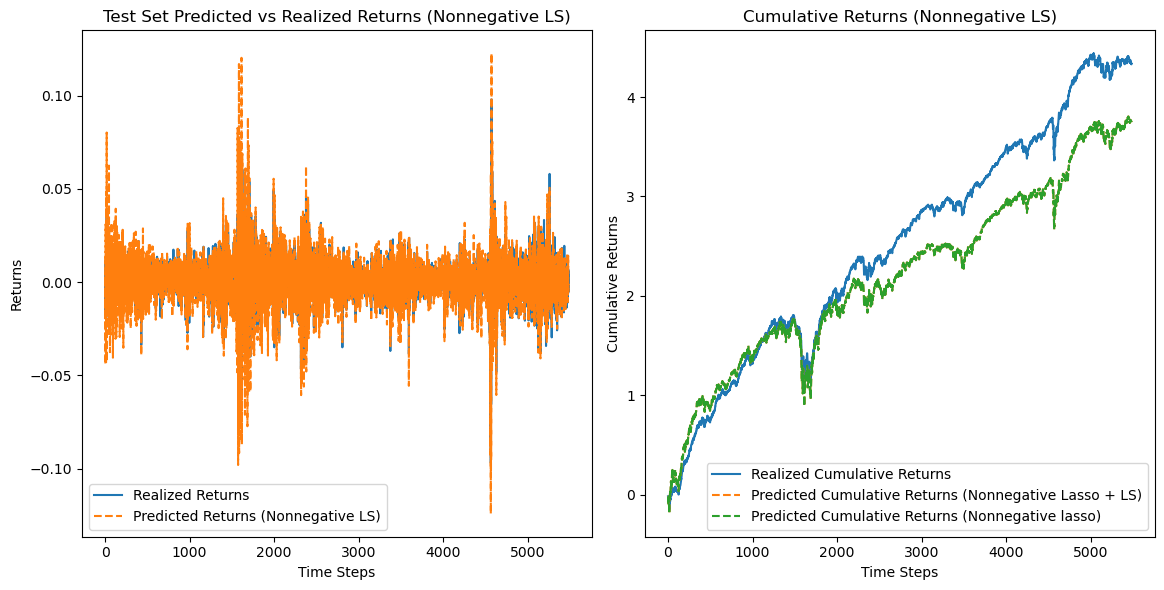

MSE for cumulative gains (portfolio value): 0.1722467597550796
MSE for cumulative losses (portfolio value): 8.615858854609134e-06


In [7]:
selected_indices = np.nonzero(lasso_best)[0]

# Extract corresponding features for non-zero weights in X_train and X_test
X_train_selected = X_train[:, selected_indices]
X_test_selected = X_test[:, selected_indices]

reg_ls = LinearRegression(positive=True)  # Assuming you have a LinearRegression implementation that supports nonnegativity
reg_ls.fit(X_train_selected, Y_train)

coefficients_ls = reg_ls.coef_

LS_coeff = lasso_best

# Modify lasso_best with the non-zero coefficients from LS
LS_coeff[selected_indices][coefficients_ls != 0] = coefficients_ls[coefficients_ls != 0]

LS_coeff = LS_coeff / np.sum(LS_coeff)

#get mean squared error for best alpha
Y_pred_LS = np.dot(X_test, LS_coeff)

# Calculate the predicted cumulative return for nonnegative LS
cum_returns_LS = np.cumsum(Y_pred_LS)

# # -----------------------------------------------------------------------------

# Evaluate the performance of the nonnegative LS model
msel_ls = mean_squared_error(Y_test, Y_pred_LS)
print(f"Mean Squared Error for nonnegative LS on test set: {msel_ls}")

plt.figure(figsize=(12, 6))

# Plot realized and predicted returns
plt.subplot(1, 2, 1)
plt.plot(Y_test, label='Realized Returns')
plt.plot(Y_pred_LS, label='Predicted Returns (Nonnegative LS)', linestyle='--')
plt.xlabel('Time Steps')
plt.ylabel('Returns')
plt.title('Test Set Predicted vs Realized Returns (Nonnegative LS)')
plt.legend()

# Plot cumulative returns for realized and predicted
plt.subplot(1, 2, 2)
plt.plot(cum_returns_real, label='Realized Cumulative Returns')
plt.plot(cum_returns_LS, label='Predicted Cumulative Returns (Nonnegative Lasso + LS)', linestyle='--')
plt.plot(cum_returns_pred, label='Predicted Cumulative Returns (Nonnegative lasso)', linestyle='--')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns (Nonnegative LS)')
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

pred_gains_LS = np.maximum(0, cum_returns_LS)
pred_losses_LS = np.minimum(0, cum_returns_LS)

# Calculate MSE for gains and losses
mse_gains_LS = mean_squared_error(gains, pred_gains_LS)
mse_losses_LS = mean_squared_error(losses, pred_losses_LS)

print("MSE for cumulative gains (portfolio value):", mse_gains_LS)
print("MSE for cumulative losses (portfolio value):", mse_losses_LS)


### We can see that LS gives smaller error when it comes to losses which is important. However, it has greater error for the gains. Our smaller portfolio is "better" than the one we are trying to replicate. 

*This is for our made up data, we need to see what happens with the real data!*

## Lasso - rebalancing every 28 days:

In [8]:
Y_pred_final = []
rebalance = 28
for i in range(0, X.shape[0]-split_index, rebalance):
    # split_index_here = int(0.8 * len(X.T) + i)  # Use 80% of the data for training

    split_index_here = 5*28 + i
    # For training, take the last 5*28 up to split_index_here
    X_train_h, Y_train_h = X[(split_index_here - 5 * 28):split_index_here], Y[(split_index_here - 5 * 28):split_index_here]

    # For testing, take only 28 after split_index_here
    X_test_h, Y_test_h = X[split_index_here:(split_index_here + 28)], Y[split_index_here:(split_index_here + 28)]

    #X_train_h, X_test_h = X_train_h.T, X_test_h.T

    # --------------------------- PICKING ALPHA:-------------------------------------

    folds = int(np.floor(days/28))
    alpha = np.linspace(10e-9, 5*10e-6, folds * 70) 
    validation_itr = TimeSeriesSplit(n_splits=folds).split(X_train_h, Y_train_h)
    plot = False

    min_scorel = np.Infinity
    best_alpha = None


    # WITHOUT T COSTS, RUN ON REGRESSION1 FUNCTION
    for j, (train_idx, test_idx) in enumerate(validation_itr):
        w = regression1(X_train_h[train_idx], Y_train_h[train_idx], X_train_h[test_idx], Y_train_h[test_idx], alpha[j], plot)
        w = w / np.sum(w)
        # print(sum(w))
        Y_pred = np.dot(X_train_h[test_idx], w)

        # Evaluate the model (you can use appropriate metrics for your problem)
        msel = mean_squared_error(Y_train_h[test_idx], Y_pred)
        # print(f"Mean Squared Error for fold {j}: {msel}")

        cumreturns = np.cumsum(Y_pred)
        cummax = np.maximum.accumulate(cumreturns)
        drawdown = (cumreturns - cummax)/cummax
        drawdown = np.min(drawdown)

        num_nonzero_coeffsl = len(w[w != 0])
        # print(f"Number of non-zero coefficients for fold {j}: {num_nonzero_coeffsl}")

        scorel = (msel + drawdown)/2

        if scorel < min_scorel:
            min_scorel = scorel
            best_alpha = alpha[j]

    

    # -------------------------------------------------------------------------------

    lasso_best = regression1(X_train_h, Y_train_h, X_test_h, Y_test_h, best_alpha)

    lasso_best = lasso_best / np.sum(lasso_best)
    print(f"Number of selected features: {np.count_nonzero(lasso_best)}")


    Y_pred = np.dot(X_test_h, lasso_best)


    if(len(Y_pred)>rebalance):
        # Y_pred_final.append(Y_pred[i:(i+28)])
        Y_pred_final.extend(list(Y_pred[:rebalance]))
    else:
        # Y_pred_final.append(Y_pred)
        Y_pred_final.extend(list(Y_pred))

    # print(Y_pred)
    # print("")
    # print(Y_pred_final)
    


Y_pred_final = np.array(Y_pred_final)


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.120e-07, tolerance: 9.185e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.289e-07, tolerance: 1.865e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 99
Number of selected features: 93


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.007e-07, tolerance: 1.186e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.110e-07, tolerance: 1.902e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 93
Number of selected features: 101


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.993e-07, tolerance: 1.236e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.841e-07, tolerance: 5.671e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 106


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.987e-07, tolerance: 4.484e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.441e-06, tolerance: 6.715e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 103


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.992e-07, tolerance: 1.777e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.171e-07, tolerance: 2.990e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 104


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.188e-07, tolerance: 8.035e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.502e-07, tolerance: 1.502e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 108


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.087e-07, tolerance: 6.397e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.427e-07, tolerance: 1.767e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 111


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.042e-07, tolerance: 1.331e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.123e-07, tolerance: 2.282e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 105


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.794e-07, tolerance: 6.024e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.750e-07, tolerance: 1.221e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 92


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.881e-07, tolerance: 7.060e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.684e-07, tolerance: 1.994e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 107


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.616e-07, tolerance: 1.326e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 100


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.656e-07, tolerance: 4.968e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.713e-07, tolerance: 1.645e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 100


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.101e-07, tolerance: 1.201e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.870e-07, tolerance: 2.209e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 98


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.570e-07, tolerance: 1.299e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.721e-07, tolerance: 1.875e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 92


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.444e-07, tolerance: 5.661e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.346e-07, tolerance: 1.249e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 95


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.014e-07, tolerance: 1.192e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.516e-07, tolerance: 2.160e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 102


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.586e-07, tolerance: 1.284e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 94


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.574e-07, tolerance: 1.652e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.442e-06, tolerance: 4.974e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 102


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.729e-07, tolerance: 4.401e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.007e-07, tolerance: 5.310e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 104


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.866e-07, tolerance: 8.643e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.965e-07, tolerance: 1.993e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 100


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.608e-07, tolerance: 1.271e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.430e-07, tolerance: 1.973e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 105


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.235e-07, tolerance: 7.457e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.120e-07, tolerance: 1.265e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 103


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.311e-07, tolerance: 5.819e-08
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 99


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.327e-07, tolerance: 6.969e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.691e-07, tolerance: 1.865e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 97


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.180e-07, tolerance: 1.137e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.244e-07, tolerance: 1.726e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 111


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.267e-07, tolerance: 4.432e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.984e-07, tolerance: 1.441e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 104


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.140e-07, tolerance: 8.095e-08
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 102


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.921e-07, tolerance: 1.136e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.008e-07, tolerance: 1.508e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 103


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.236e-07, tolerance: 4.076e-08
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 112


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.740e-07, tolerance: 6.127e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.404e-07, tolerance: 1.119e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 110


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.340e-07, tolerance: 6.007e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.358e-07, tolerance: 1.354e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 117


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.241e-07, tolerance: 1.118e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 103


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.068e-08, tolerance: 3.829e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.893e-07, tolerance: 9.622e-08
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 105


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.826e-07, tolerance: 7.035e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.933e-07, tolerance: 1.690e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 108


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.392e-07, tolerance: 9.430e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.954e-07, tolerance: 1.658e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 105


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.670e-07, tolerance: 7.173e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.244e-07, tolerance: 1.282e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 93


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.990e-07, tolerance: 6.697e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.204e-07, tolerance: 3.966e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 106


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.528e-06, tolerance: 6.856e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 94


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.987e-07, tolerance: 2.805e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.183e-07, tolerance: 3.655e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 101


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.857e-07, tolerance: 8.126e-08
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 100


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.078e-07, tolerance: 8.256e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.767e-07, tolerance: 1.458e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 94


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.991e-07, tolerance: 7.151e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.275e-07, tolerance: 1.219e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 103


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.655e-07, tolerance: 4.767e-08
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 93


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.174e-07, tolerance: 4.621e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.621e-07, tolerance: 2.916e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 106


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.783e-07, tolerance: 3.239e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 101


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.314e-07, tolerance: 4.480e-08
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 92


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.830e-07, tolerance: 7.840e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.928e-07, tolerance: 2.044e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 105


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.723e-07, tolerance: 7.777e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.220e-07, tolerance: 3.487e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 103


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.049e-06, tolerance: 5.726e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.380e-06, tolerance: 6.902e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 111


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.433e-07, tolerance: 1.425e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.883e-07, tolerance: 2.846e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 111


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.380e-07, tolerance: 2.022e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.089e-06, tolerance: 4.646e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 115


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.480e-06, tolerance: 5.846e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.952e-06, tolerance: 1.021e-06
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 118


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.275e-06, tolerance: 7.652e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.002e-06, tolerance: 1.167e-06
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 111


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.764e-06, tolerance: 6.847e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.745e-06, tolerance: 8.331e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 112


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.112e-06, tolerance: 4.966e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.166e-06, tolerance: 6.142e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 95


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.301e-07, tolerance: 8.533e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.650e-07, tolerance: 1.976e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 98


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.560e-07, tolerance: 4.168e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 94


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.967e-07, tolerance: 1.861e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.222e-06, tolerance: 3.275e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 90


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.412e-06, tolerance: 2.588e-06
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.807e-06, tolerance: 5.094e-06
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 99


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.445e-06, tolerance: 6.981e-06
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 105


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.014e-06, tolerance: 3.661e-06
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.386e-06, tolerance: 4.560e-06
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 110


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.105e-06, tolerance: 1.488e-06
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.898e-06, tolerance: 2.708e-06
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 113


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.601e-06, tolerance: 2.294e-06
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.334e-06, tolerance: 3.325e-06
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 113


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.266e-06, tolerance: 2.258e-06
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.583e-06, tolerance: 2.755e-06
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 111


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.688e-07, tolerance: 6.414e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.580e-06, tolerance: 1.045e-06
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 111


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.770e-06, tolerance: 8.086e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.357e-06, tolerance: 1.131e-06
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 101


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.077e-07, tolerance: 3.739e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.606e-06, tolerance: 6.735e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 109


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.890e-06, tolerance: 5.788e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.939e-06, tolerance: 8.439e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 103


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.930e-07, tolerance: 2.319e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.762e-07, tolerance: 5.361e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 106


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.752e-07, tolerance: 3.231e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.139e-06, tolerance: 5.255e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 100


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.907e-07, tolerance: 1.567e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.145e-07, tolerance: 3.437e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 102


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.664e-07, tolerance: 2.072e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.971e-07, tolerance: 3.454e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 91


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.014e-07, tolerance: 1.216e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.696e-07, tolerance: 2.252e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 107


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.650e-07, tolerance: 1.089e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.935e-06, tolerance: 1.050e-06
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 100


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.294e-06, tolerance: 1.314e-06
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.465e-06, tolerance: 1.545e-06
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 105


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.125e-06, tolerance: 5.826e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.598e-06, tolerance: 8.282e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 112


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.805e-07, tolerance: 2.765e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.557e-06, tolerance: 4.930e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 115


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.492e-07, tolerance: 1.821e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.555e-07, tolerance: 3.160e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 99


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.122e-07, tolerance: 1.366e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.841e-07, tolerance: 4.072e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 86


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.421e-07, tolerance: 2.524e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 97


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.499e-07, tolerance: 9.000e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.110e-07, tolerance: 1.957e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 104


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.453e-07, tolerance: 1.110e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.210e-07, tolerance: 3.093e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 101


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.607e-07, tolerance: 1.779e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.085e-07, tolerance: 3.114e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 102


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.535e-07, tolerance: 3.645e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.169e-07, tolerance: 6.174e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 106


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.815e-06, tolerance: 5.025e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.101e-06, tolerance: 1.717e-06
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 103


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.039e-06, tolerance: 1.679e-06
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.939e-06, tolerance: 2.570e-06
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 107


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.968e-06, tolerance: 1.679e-06
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.273e-06, tolerance: 2.463e-06
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 102


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.765e-06, tolerance: 1.539e-06
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.450e-06, tolerance: 1.995e-06
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 100


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.746e-06, tolerance: 9.683e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.974e-06, tolerance: 1.106e-06
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 102


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.194e-07, tolerance: 3.857e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 96


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.746e-07, tolerance: 9.302e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.318e-06, tolerance: 2.615e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 111


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.037e-07, tolerance: 1.809e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.967e-07, tolerance: 3.786e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 105


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.616e-07, tolerance: 1.813e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.173e-06, tolerance: 4.315e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 108


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.602e-07, tolerance: 2.369e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.143e-06, tolerance: 4.775e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 106


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.141e-06, tolerance: 3.967e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.176e-06, tolerance: 4.997e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 105


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.634e-07, tolerance: 9.463e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.333e-07, tolerance: 1.976e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 98


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.433e-07, tolerance: 1.044e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.747e-07, tolerance: 2.118e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 89


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.922e-07, tolerance: 1.235e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.858e-07, tolerance: 1.732e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 104


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.696e-07, tolerance: 4.154e-08
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 108


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.471e-07, tolerance: 4.115e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.410e-07, tolerance: 1.155e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 103


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.589e-07, tolerance: 8.043e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.413e-07, tolerance: 1.849e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 105


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.014e-07, tolerance: 1.180e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.616e-07, tolerance: 1.918e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 107


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.516e-07, tolerance: 8.473e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.599e-07, tolerance: 3.008e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 109


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.909e-07, tolerance: 2.898e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 107


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.614e-07, tolerance: 5.335e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.787e-07, tolerance: 1.438e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 110


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.365e-07, tolerance: 6.044e-08
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 113


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.115e-07, tolerance: 6.598e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.985e-07, tolerance: 1.150e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 111


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.610e-07, tolerance: 6.420e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.832e-07, tolerance: 1.057e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 113


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.538e-07, tolerance: 7.411e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.522e-07, tolerance: 1.417e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 111


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.574e-07, tolerance: 1.034e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.135e-07, tolerance: 1.730e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 101


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.254e-07, tolerance: 7.991e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.287e-07, tolerance: 1.079e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 99


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.077e-07, tolerance: 3.193e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.729e-08, tolerance: 4.717e-08
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 94


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.588e-08, tolerance: 1.840e-08
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 98


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.338e-07, tolerance: 5.537e-08
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 97


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.094e-07, tolerance: 3.655e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.503e-07, tolerance: 1.706e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 103


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.210e-07, tolerance: 1.581e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.133e-07, tolerance: 1.964e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 103


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.339e-07, tolerance: 4.520e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.966e-07, tolerance: 1.557e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 99


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.764e-07, tolerance: 1.089e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.168e-07, tolerance: 2.077e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 107


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.386e-07, tolerance: 8.889e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.225e-07, tolerance: 2.415e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 108


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.671e-07, tolerance: 1.441e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.028e-07, tolerance: 1.849e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 101


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.332e-07, tolerance: 5.103e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.751e-07, tolerance: 1.305e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 96


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.817e-07, tolerance: 1.919e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 97


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.779e-07, tolerance: 1.298e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.087e-06, tolerance: 4.842e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 93


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.564e-06, tolerance: 6.099e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 95


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.907e-07, tolerance: 3.067e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 106


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.896e-07, tolerance: 8.885e-08
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 107


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.366e-07, tolerance: 1.337e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.203e-06, tolerance: 4.503e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 105


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.759e-06, tolerance: 5.391e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.173e-06, tolerance: 6.609e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 99


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.785e-07, tolerance: 1.681e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.646e-07, tolerance: 2.829e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 111


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.919e-07, tolerance: 1.013e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.900e-07, tolerance: 1.824e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 110


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.400e-07, tolerance: 4.917e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.225e-06, tolerance: 6.199e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 109


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.022e-07, tolerance: 5.683e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.491e-06, tolerance: 6.691e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 121


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.490e-07, tolerance: 5.125e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.085e-07, tolerance: 1.784e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 110


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.708e-07, tolerance: 1.312e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.236e-07, tolerance: 1.950e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 117


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.529e-07, tolerance: 7.961e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.051e-07, tolerance: 1.210e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 108


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.231e-07, tolerance: 4.413e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.676e-08, tolerance: 7.329e-08
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 111


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.112e-07, tolerance: 4.507e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.007e-08, tolerance: 7.514e-08
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 109


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.223e-07, tolerance: 3.320e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.715e-08, tolerance: 7.000e-08
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 116


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.158e-07, tolerance: 3.572e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.489e-07, tolerance: 1.050e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 113


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.773e-07, tolerance: 6.758e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.060e-07, tolerance: 1.326e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 117


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.619e-07, tolerance: 6.445e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.937e-08, tolerance: 9.465e-08
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 106


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.200e-07, tolerance: 4.478e-08
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 125


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.149e-08, tolerance: 2.654e-08
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 108


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.434e-08, tolerance: 2.663e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.336e-07, tolerance: 7.147e-08
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 114


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.488e-07, tolerance: 5.140e-08
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 110


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.258e-07, tolerance: 3.377e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.739e-07, tolerance: 2.759e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 106


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.328e-07, tolerance: 2.272e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.066e-06, tolerance: 3.491e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 110


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.538e-07, tolerance: 1.272e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.835e-07, tolerance: 1.972e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 106


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.273e-07, tolerance: 6.656e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.188e-07, tolerance: 1.127e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 111


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.743e-07, tolerance: 6.994e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.138e-07, tolerance: 1.430e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 118


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.860e-07, tolerance: 5.338e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.807e-07, tolerance: 1.210e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 112


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.214e-07, tolerance: 8.161e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.946e-07, tolerance: 2.238e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 111


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.162e-07, tolerance: 1.857e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.100e-06, tolerance: 4.271e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 103


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.570e-06, tolerance: 5.800e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.426e-06, tolerance: 7.392e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 124


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.059e-06, tolerance: 4.840e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.979e-06, tolerance: 5.709e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 117


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.610e-07, tolerance: 6.804e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.650e-07, tolerance: 1.376e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 121


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.748e-07, tolerance: 9.298e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.174e-07, tolerance: 1.577e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 120


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.515e-07, tolerance: 6.096e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.517e-07, tolerance: 2.288e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 119


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.178e-07, tolerance: 1.539e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.338e-07, tolerance: 2.221e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 115


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.147e-07, tolerance: 5.934e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.006e-07, tolerance: 2.732e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 105


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.799e-07, tolerance: 1.977e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.046e-07, tolerance: 2.769e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 107


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.768e-07, tolerance: 1.012e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.781e-07, tolerance: 1.622e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 115


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.277e-05, tolerance: 3.971e-06
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.223e-05, tolerance: 6.342e-06
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 119


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.638e-08, tolerance: 7.063e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.195e-07, tolerance: 3.437e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 115


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.641e-06, tolerance: 4.993e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.564e-06, tolerance: 5.628e-06
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 117


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.086e-05, tolerance: 6.426e-06
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.651e-05, tolerance: 7.177e-06
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 119


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.082e-06, tolerance: 4.056e-06
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.013e-05, tolerance: 4.164e-06
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 118


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.224e-06, tolerance: 1.099e-06
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.069e-06, tolerance: 1.235e-06
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 113


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.655e-06, tolerance: 6.286e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.497e-06, tolerance: 7.895e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 119
Number of selected features: 104


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.219e-07, tolerance: 2.643e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.579e-07, tolerance: 4.459e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 114


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.295e-07, tolerance: 2.523e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.806e-06, tolerance: 4.789e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 112


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.085e-07, tolerance: 1.302e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.747e-06, tolerance: 2.055e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 105


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.903e-07, tolerance: 1.147e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.239e-07, tolerance: 2.915e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 115


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.463e-07, tolerance: 2.094e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.480e-06, tolerance: 4.010e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 109


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.037e-07, tolerance: 1.652e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.054e-07, tolerance: 2.681e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 114


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.759e-07, tolerance: 1.920e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.297e-07, tolerance: 2.905e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 111


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.249e-07, tolerance: 1.087e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.694e-07, tolerance: 2.299e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 114


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.844e-07, tolerance: 1.299e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.726e-07, tolerance: 2.294e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 106


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.089e-07, tolerance: 1.037e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.692e-07, tolerance: 2.513e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 102


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.796e-07, tolerance: 1.828e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.693e-07, tolerance: 2.759e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 97


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.108e-07, tolerance: 1.519e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.729e-07, tolerance: 3.664e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 96


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.163e-06, tolerance: 5.392e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.141e-06, tolerance: 1.044e-06
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 105


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.774e-07, tolerance: 4.195e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.043e-06, tolerance: 9.301e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 110


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.121e-06, tolerance: 7.669e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.694e-06, tolerance: 1.352e-06
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 99


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.900e-07, tolerance: 2.682e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.397e-06, tolerance: 8.953e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 104


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.530e-06, tolerance: 1.025e-06
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.117e-06, tolerance: 1.408e-06
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 87


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.264e-07, tolerance: 3.634e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.751e-06, tolerance: 7.163e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 101


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.994e-07, tolerance: 4.216e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.104e-06, tolerance: 9.146e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 98


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.934e-06, tolerance: 1.773e-06
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.618e-06, tolerance: 2.138e-06
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 111


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.537e-06, tolerance: 1.400e-06
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.993e-06, tolerance: 1.628e-06
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 101


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.355e-06, tolerance: 5.830e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.066e-06, tolerance: 8.030e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 105


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.594e-07, tolerance: 2.292e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.048e-06, tolerance: 4.702e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 109


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.929e-07, tolerance: 2.040e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.250e-07, tolerance: 4.463e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 104


MSE for cumulative gains (portfolio value): 0.14047684943036975
MSE for cumulative losses (portfolio value): 1.1179893371862596e-05


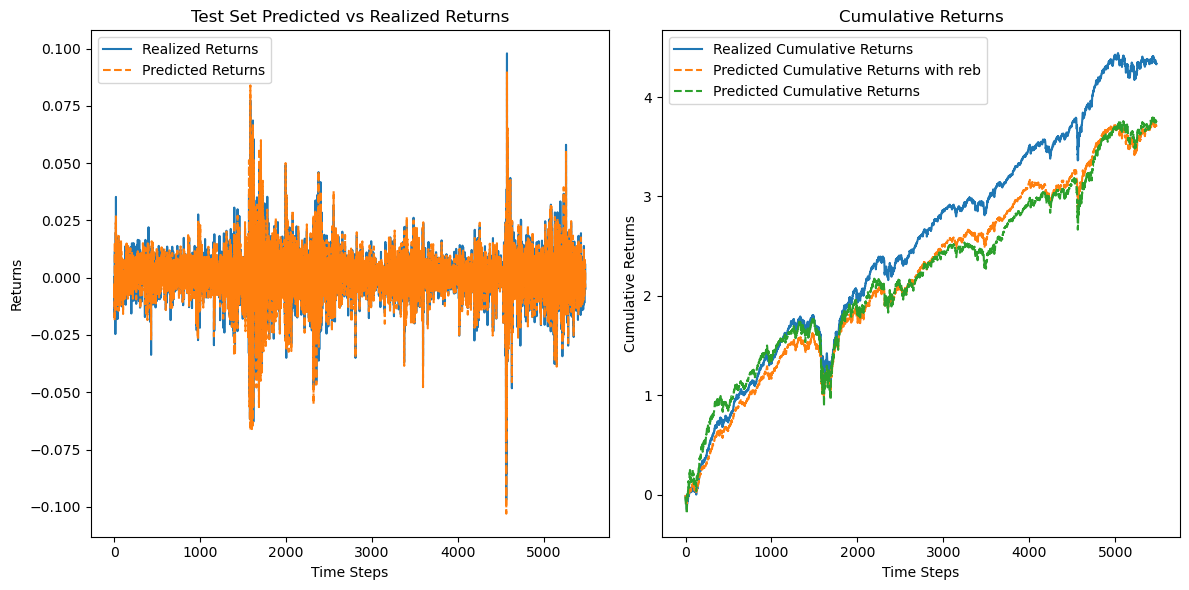

In [9]:
cum_returns_pred_final = np.cumsum(Y_pred_final)


pred_gains_fin = np.maximum(0, cum_returns_pred_final)
pred_losses_fin = np.minimum(0, cum_returns_pred_final)

# Calculate MSE for gains and losses
mse_gains_fin = mean_squared_error(gains, pred_gains_fin)
mse_losses_fin = mean_squared_error(losses, pred_losses_fin)

print("MSE for cumulative gains (portfolio value):", mse_gains_fin)
print("MSE for cumulative losses (portfolio value):", mse_losses_fin)


# Calculate the drawdown for test set as before 
cum_max = np.maximum.accumulate(cum_returns_pred_final)
drawdownltest = (cum_returns_pred_final - cum_max)/cum_max
drawdown_test = np.min(drawdownltest)


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(Y_test, label='Realized Returns')
plt.plot(Y_pred_final, label='Predicted Returns', linestyle='--')
plt.xlabel('Time Steps')
plt.ylabel('Returns')
plt.title('Test Set Predicted vs Realized Returns')
plt.legend()

# Plot the cumulative returns
plt.subplot(1, 2, 2)
plt.plot(cum_returns_real, label='Realized Cumulative Returns')
plt.plot(cum_returns_pred_final, label='Predicted Cumulative Returns with reb', linestyle='--')
plt.plot(cum_returns_pred, label='Predicted Cumulative Returns', linestyle='--')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns')
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()



In [10]:
if(mse_gains_fin < mse_gains):
    print("With rebalancing using Lasso we manage to reduce error on the gains")
else:
    print("With rebalancing using Lasso we DON'T manage to reduce error on the gains")

if(mse_losses_fin < mse_losses):
    print("With rebalancing using Lasso we manage to reduce error on the losses")
else:
    print("With rebalancing using Lasso we DON'T manage to reduce error on the losses")

With rebalancing using Lasso we manage to reduce error on the gains
With rebalancing using Lasso we DON'T manage to reduce error on the losses


## Lasso + LS - rebalancing every 28 days:

In [12]:

Y_pred_final_LS = []
rebalance = 28
for i in range(0, X.shape[0]-split_index, rebalance):
    # split_index_here = int(0.8 * len(X.T) + i)  # Use 80% of the data for training

    split_index_here = 5*28 + i
    print(split_index_here)
    # For training, take the last 5*28 up to split_index_here
    X_train_h, Y_train_h = X[(split_index_here - 5 * 28):split_index_here], Y[(split_index_here - 5 * 28):split_index_here]

    # For testing, take only 28 after split_index_here
    X_test_h, Y_test_h = X[split_index_here:(split_index_here + 28)], Y[split_index_here:(split_index_here + 28)]

    # X_train_h, X_test_h = X_train_h.T, X_test_h.T

    # --------------------------- PICKING ALPHA:-------------------------------------

    folds = int(np.floor(days/28))
    alpha = np.linspace(10e-9, 5*10e-6, folds) 
    validation_itr = TimeSeriesSplit(n_splits=folds).split(X_train_h, Y_train_h)
    plot = False

    min_scorel = np.Infinity
    best_alpha = None


    # WITHOUT T COSTS, RUN ON REGRESSION1 FUNCTION
    for j, (train_idx, test_idx) in enumerate(validation_itr):
        w = regression1(X_train_h[train_idx], Y_train_h[train_idx], X_train_h[test_idx], Y_train_h[test_idx], alpha[j], plot)
        w = w / np.sum(w)
        # print(sum(w))
        Y_pred = np.dot(X_train_h[test_idx], w)

        # Evaluate the model (you can use appropriate metrics for your problem)

        if np.isnan(Y_train_h[test_idx]).any():
            print("Found a NaN in Y_train_h")
            print(Y_train_h[test_idx])
        
        if np.isnan(Y_pred).any():
            print("Found a NaN in Y_pred")
            print(Y_pred)
        msel = mean_squared_error(Y_train_h[test_idx], Y_pred)
        # print(f"Mean Squared Error for fold {j}: {msel}")

        cumreturns = np.cumsum(Y_pred)
        cummax = np.maximum.accumulate(cumreturns)
        drawdown = (cumreturns - cummax)/cummax
        drawdown = np.min(drawdown)

        num_nonzero_coeffsl = len(w[w != 0])
        # print(f"Number of non-zero coefficients for fold {j}: {num_nonzero_coeffsl}")

        scorel = (msel + drawdown)/2

        if scorel < min_scorel:
            min_scorel = scorel
            best_alpha = alpha[j]

    

    # -------------------------------------------------------------------------------

    lasso_best = regression1(X_train_h, Y_train_h, X_test_h, Y_test_h, best_alpha)

    lasso_best = lasso_best / np.sum(lasso_best)
    print(f"Number of selected features: {np.count_nonzero(lasso_best)}")
    

    # ________________________________________________________________
    selected_indices_h = np.nonzero(lasso_best)[0]

    # print("Length of selected_indices_h = ", len(selected_indices_h))

    # Extract corresponding features for non-zero weights in X_train and X_test
    X_train_selected_h = X_train_h[:, selected_indices_h]
    X_test_selected_h = X_test_h[:, selected_indices_h]

    # print("Shape of X_train_selected_h = ", X_train_selected_h.shape)

    reg_ls = LinearRegression(positive=True)  # Assuming you have a LinearRegression implementation that supports nonnegativity
    reg_ls.fit(X_train_selected_h, Y_train_h)

    coefficients_ls = reg_ls.coef_

    # print("Length of reg_ls.coef_ = ", len(reg_ls.coef_))


    LS_coeff_h = lasso_best

    # print("hereeeee 1 - ", LS_coeff_h[selected_indices_h])
    # print("hereeeee 2 - ", selected_indices_h.shape)
    # print("hereeeee 3 - ", LS_coeff_h[selected_indices_h].shape)
    # print("hereeeee 4 - ", coefficients_ls.shape)
    # print("hereeeee 5 - ", sum(coefficients_ls != 0))

    if (sum(coefficients_ls != 0) < np.count_nonzero(lasso_best)):
        LS_coeff_h = lasso_best
        print("DOING LASSO INSTEAD!")

    else:
        # Modify lasso_best with the non-zero coefficients from LS
        LS_coeff_h[selected_indices_h] = coefficients_ls[coefficients_ls != 0]


    LS_coeff_h = LS_coeff_h / np.sum(LS_coeff_h)

    Y_pred = np.dot(X_test_h, LS_coeff_h)

    if(len(Y_pred)>rebalance):
        # Y_pred_final.append(Y_pred[i:(i+28)])
        Y_pred_final_LS.extend(list(Y_pred[:rebalance]))
    else:
        # Y_pred_final.append(Y_pred)
        Y_pred_final_LS.extend(list(Y_pred))

    # print(Y_pred)
    # print("")
    # print(Y_pred_final)
    


Y_pred_final_LS = np.array(Y_pred_final_LS)

# # -----------------------------------------------------------------------------

cum_returns_pred_final_LS = np.cumsum(Y_pred_final_LS)


pred_gains_fin_LS = np.maximum(0, cum_returns_pred_final_LS)
pred_losses_fin_LS = np.minimum(0, cum_returns_pred_final_LS)

# Calculate MSE for gains and losses
mse_gains_fin_LS = mean_squared_error(gains, pred_gains_fin_LS)
mse_losses_fin_LS = mean_squared_error(losses, pred_losses_fin_LS)

print("MSE for cumulative gains (portfolio value):", mse_gains_fin_LS)
print("MSE for cumulative losses (portfolio value):", mse_losses_fin_LS)


# Calculate the drawdown for test set as before 
cum_max = np.maximum.accumulate(cum_returns_pred_final_LS)
drawdownltest = (cum_returns_pred_final_LS - cum_max)/cum_max
drawdown_test = np.min(drawdownltest)


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(Y_test, label='Realized Returns')
plt.plot(Y_pred_final_LS, label='Predicted Returns', linestyle='--')
plt.xlabel('Time Steps')
plt.ylabel('Returns')
plt.title('Test Set Predicted vs Realized Returns')
plt.legend()

# Plot the cumulative returns
plt.subplot(1, 2, 2)
plt.plot(cum_returns_real, label='Realized Cumulative Returns')
plt.plot(cum_returns_pred_final_LS, label='Predicted Cumulative Returns Lasso + LS', linestyle='--')
plt.plot(cum_returns_pred_final, label='Predicted Cumulative Returns with Lasso', linestyle='--')
# plt.plot(cum_returns_LS, label='Predicted Cumulative Returns without rebalacing', linestyle='--')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns with rebalancing')
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()




140


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.120e-07, tolerance: 9.185e-08
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 40
DOING LASSO INSTEAD!
168


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.007e-07, tolerance: 1.186e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 93
196


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.610e-07, tolerance: 7.145e-08
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 91
224


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.988e-07, tolerance: 2.753e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 60
DOING LASSO INSTEAD!
252
Number of selected features: 28
DOING LASSO INSTEAD!
280


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.993e-07, tolerance: 1.236e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.987e-07, tolerance: 4.484e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 23
DOING LASSO INSTEAD!
308


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.992e-07, tolerance: 1.777e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 104
DOING LASSO INSTEAD!
336


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.188e-07, tolerance: 8.035e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.087e-07, tolerance: 6.397e-08
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 53
DOING LASSO INSTEAD!
364
Number of selected features: 111
DOING LASSO INSTEAD!
392


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.042e-07, tolerance: 1.331e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.794e-07, tolerance: 6.024e-08
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 34
DOING LASSO INSTEAD!
420
Number of selected features: 44
DOING LASSO INSTEAD!
448
Number of selected features: 22
DOING LASSO INSTEAD!
476


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.881e-07, tolerance: 7.060e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.616e-07, tolerance: 1.326e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 14
504
Number of selected features: 31
DOING LASSO INSTEAD!
532


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.101e-07, tolerance: 1.201e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.570e-07, tolerance: 1.299e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 19
560
Number of selected features: 21
DOING LASSO INSTEAD!
588
Number of selected features: 26
DOING LASSO INSTEAD!
616


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.014e-07, tolerance: 1.192e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.586e-07, tolerance: 1.284e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 18
644
Number of selected features: 49
DOING LASSO INSTEAD!
672
Number of selected features: 102
DOING LASSO INSTEAD!
700
Number of selected features: 32
DOING LASSO INSTEAD!
728


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.866e-07, tolerance: 8.643e-08
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 100
756
Number of selected features: 9
784


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.608e-07, tolerance: 1.271e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.235e-07, tolerance: 7.457e-08
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 6
812
Number of selected features: 20
DOING LASSO INSTEAD!
840


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.311e-07, tolerance: 5.819e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.327e-07, tolerance: 6.969e-08
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 14
868
Number of selected features: 25
DOING LASSO INSTEAD!
896


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.180e-07, tolerance: 1.137e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.267e-07, tolerance: 4.432e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 46
DOING LASSO INSTEAD!
924
Number of selected features: 4
952


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.921e-07, tolerance: 1.136e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.236e-07, tolerance: 4.076e-08
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 5
980
Number of selected features: 115
1008


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.740e-07, tolerance: 6.127e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.340e-07, tolerance: 6.007e-08
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 24
1036
Number of selected features: 8
1064


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.241e-07, tolerance: 1.118e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.068e-08, tolerance: 3.829e-08
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 13
1092
Number of selected features: 24
DOING LASSO INSTEAD!
1120


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.826e-07, tolerance: 7.035e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.392e-07, tolerance: 9.430e-08
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 21
DOING LASSO INSTEAD!
1148
Number of selected features: 26
DOING LASSO INSTEAD!
1176


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.670e-07, tolerance: 7.173e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.990e-07, tolerance: 6.697e-08
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 34
DOING LASSO INSTEAD!
1204
Number of selected features: 106
DOING LASSO INSTEAD!
1232
Number of selected features: 32
DOING LASSO INSTEAD!
1260
Number of selected features: 44
DOING LASSO INSTEAD!
1288
Number of selected features: 11
1316


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.987e-07, tolerance: 2.805e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.857e-07, tolerance: 8.126e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 9
DOING LASSO INSTEAD!
1344
Number of selected features: 18
DOING LASSO INSTEAD!
1372
Number of selected features: 99
1400


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.991e-07, tolerance: 7.151e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.655e-07, tolerance: 4.767e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 106
1428
Number of selected features: 57
DOING LASSO INSTEAD!
1456


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.314e-07, tolerance: 4.480e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.830e-07, tolerance: 7.840e-08
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 18
1484
Number of selected features: 21
DOING LASSO INSTEAD!
1512


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.723e-07, tolerance: 7.777e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.952e-07, tolerance: 3.511e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 103
1540
Number of selected features: 29
DOING LASSO INSTEAD!
1568


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.433e-07, tolerance: 1.425e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.380e-07, tolerance: 2.022e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 44
DOING LASSO INSTEAD!
1596
Number of selected features: 45
DOING LASSO INSTEAD!
1624
Number of selected features: 118
DOING LASSO INSTEAD!
1652
Number of selected features: 30
DOING LASSO INSTEAD!
1680
Number of selected features: 62
DOING LASSO INSTEAD!
1708
Number of selected features: 65
DOING LASSO INSTEAD!
1736


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.301e-07, tolerance: 8.533e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.768e-05, tolerance: 4.357e-06
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 98
DOING LASSO INSTEAD!
1764
Number of selected features: 63
DOING LASSO INSTEAD!
1792


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.967e-07, tolerance: 1.861e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.997e-05, tolerance: 8.151e-06
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 90
DOING LASSO INSTEAD!
1820
Number of selected features: 99
1848


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.992e-06, tolerance: 5.694e-06
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 66
DOING LASSO INSTEAD!
1876
Number of selected features: 74
DOING LASSO INSTEAD!
1904
Number of selected features: 49
DOING LASSO INSTEAD!
1932
Number of selected features: 41
DOING LASSO INSTEAD!
1960
Number of selected features: 55
DOING LASSO INSTEAD!
1988


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.688e-07, tolerance: 6.414e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 111
2016
Number of selected features: 21
2044


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.077e-07, tolerance: 3.739e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 37
DOING LASSO INSTEAD!
2072
Number of selected features: 20
DOING LASSO INSTEAD!
2100


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.930e-07, tolerance: 2.319e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.752e-07, tolerance: 3.231e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 18
DOING LASSO INSTEAD!
2128
Number of selected features: 29
DOING LASSO INSTEAD!
2156


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.907e-07, tolerance: 1.567e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.664e-07, tolerance: 2.072e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 26
DOING LASSO INSTEAD!
2184
Number of selected features: 19
DOING LASSO INSTEAD!
2212


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.014e-07, tolerance: 1.216e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.650e-07, tolerance: 1.089e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 32
DOING LASSO INSTEAD!
2240
Number of selected features: 100
DOING LASSO INSTEAD!
2268
Number of selected features: 23
DOING LASSO INSTEAD!
2296
Number of selected features: 49
DOING LASSO INSTEAD!
2324
Number of selected features: 115
DOING LASSO INSTEAD!
2352


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.805e-07, tolerance: 2.765e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.492e-07, tolerance: 1.821e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 15
DOING LASSO INSTEAD!
2380
Number of selected features: 51
DOING LASSO INSTEAD!
2408
Number of selected features: 14
2436
Number of selected features: 38
DOING LASSO INSTEAD!
2464


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.499e-07, tolerance: 9.000e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.453e-07, tolerance: 1.110e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 101
2492


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.607e-07, tolerance: 1.779e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.787e-05, tolerance: 2.706e-06
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 102
DOING LASSO INSTEAD!
2520
Number of selected features: 32
DOING LASSO INSTEAD!
2548


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.816e-05, tolerance: 4.114e-06
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 103
DOING LASSO INSTEAD!
2576
Number of selected features: 58
DOING LASSO INSTEAD!
2604


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.163e-06, tolerance: 3.337e-06
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 102
2632


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.305e-05, tolerance: 2.418e-06
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 100
DOING LASSO INSTEAD!
2660
Number of selected features: 17
DOING LASSO INSTEAD!
2688
Number of selected features: 18
DOING LASSO INSTEAD!
2716
Number of selected features: 30
DOING LASSO INSTEAD!
2744


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.746e-07, tolerance: 9.302e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.037e-07, tolerance: 1.809e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 20
DOING LASSO INSTEAD!
2772
Number of selected features: 21


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.616e-07, tolerance: 1.813e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.602e-07, tolerance: 2.369e-07
  model = cd_fast.enet_coordinate_descent(


DOING LASSO INSTEAD!
2800
Number of selected features: 103
2828
Number of selected features: 23
DOING LASSO INSTEAD!
2856


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.634e-07, tolerance: 9.463e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.433e-07, tolerance: 1.044e-07
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 20
DOING LASSO INSTEAD!
2884
Number of selected features: 22
DOING LASSO INSTEAD!
2912


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.922e-07, tolerance: 1.235e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.696e-07, tolerance: 4.154e-08
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 7
2940
Number of selected features: 19
2968


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.471e-07, tolerance: 4.115e-08
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 40
DOING LASSO INSTEAD!
2996
Number of selected features: 22
DOING LASSO INSTEAD!
3024
Number of selected features: 15
3052


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.589e-07, tolerance: 8.043e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.014e-07, tolerance: 1.180e-07
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 27
DOING LASSO INSTEAD!
3080
Number of selected features: 21
3108
Number of selected features: 12
3136


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.614e-07, tolerance: 5.335e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.365e-07, tolerance: 6.044e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 38
DOING LASSO INSTEAD!
3164
Number of selected features: 8
3192
Number of selected features: 17
3220


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.610e-07, tolerance: 6.420e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.538e-07, tolerance: 7.411e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might

Number of selected features: 18
DOING LASSO INSTEAD!
3248
Number of selected features: 7
3276
Number of selected features: 3
3304


/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.254e-07, tolerance: 7.991e-08
  model = cd_fast.enet_coordinate_descent(
/Users/macos/financial-machine-learning-projects-group2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.077e-07, tolerance: 3.193e-08
  model = cd_fast.enet_coordinate_descent(
/var/folders/7h/f9myv4011zd0fx14j4by1gdc0000gn/T/ipykernel_4561/2270501662.py:30: RuntimeWarning: invalid value encountered in divide
  w = w / np.sum(w)


Found a NaN in Y_pred
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan]


ValueError: Input contains NaN.

In [ ]:
if(mse_gains_fin_LS < mse_gains_LS):
    print("With rebalancing using Lasso + LS we manage to reduce error on the gains")
else:
    print("With rebalancing using Lasso + LS we DON'T manage to reduce error on the gains")

if(mse_losses_fin_LS < mse_losses_LS):
    print("With rebalancing using Lasso + LS we manage to reduce error on the losses")
else:
    print("With rebalancing using Lasso + LS we DON'T manage to reduce error on the losses")

: 